In [18]:
1+2

3

In [19]:
from langgraph.graph import StateGraph, START, END
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [20]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [21]:
from langchain_groq import ChatGroq

In [22]:
llm = ChatGroq(
    model="qwen/qwen3-32b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2,
    # other params...
)

In [23]:
class State(TypedDict):
    messages:Annotated[list, add_messages]

In [24]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}##it gives the all stored messages to the llm

In [ ]:
graph_builder = StateGraph(State)#now state appends the response as dict to the list messages this state passes as parameter for nodes and also after node execution the state is updated

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

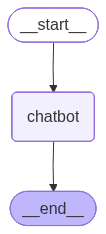

In [28]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass

In [ ]:
response = graph.invoke({"messages":"Hello How Are You?"})  ### What Happens is that before chatbot is called it goes through the state which is a list of messages and then chatbot is called and after chatbot returns the response it is added to the list of messages in state

In [31]:
response['messages'][-1].content

"Hello! I'm doing well, thank you for asking. How can I assist you today? 😊"

In [34]:
for event in graph.stream({"messages":"Hello How Are You?"}):
    for value in event.values():
        print(value['messages'][-1].content)

Hello! I'm doing well, thank you for asking. How have you been? I'd love to hear how your day is going! 😊


In [35]:
##tool for chatbot
response = graph.invoke({"messages":"what date is today?"}) 
print(response['messages'][-1].content)

I don't have access to real-time data or the current date. However, you can easily check today's date by looking at your device's clock, calendar, or searching online. Let me know if there's anything else I can assist you with!


In [ ]:
from langchain.tools import tool
from langchain_tavily import TavilySearch

# @tool
def get_tavily_search_results(query: str) -> str:
    """
    Useful for when you need to answer questions about current events. Input should be a search query.

    Args:
        query (str): The search query.

    Returns:
        str: The search results.
    """
    
    search = TavilySearch()
    return search.run(query)

# @tool in langchain we use tool DECORATOR THEN BIND THE TOOL TO LLM WITH llm.bind_tools
def multiply(x: float, y: float) -> float:
    """
    Useful for multiplying two numbers.

    Args:
        x (float): The first number.
        y (float): The second number.

    Returns:
        float: The product of x and y.
    """
    return x * y

In [45]:
tools = [get_tavily_search_results, multiply]

llm_with_tools = llm.bind_tools(tools)
    

In [46]:
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 16384, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001DBD6938050>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001DBD6938A50>, model_name='qwen/qwen3-32b', temperature=1e-08, reasoning_format='parsed', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_tavily_search_results', 'description': 'Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'The search query.', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'descr

In [ ]:
llm.invoke("what date is today?")# we need to call tools also

AIMessage(content="I don't have access to real-time data or the current date. To find today's date, you can check your device's clock, calendar app, or search online. Let me know if you need help with anything else! 😊", additional_kwargs={'reasoning_content': "Okay, the user is asking for today's date. Let me check my system. Hmm, I don't have real-time data, so I can't provide the current date directly. I should inform them that I can't access real-time information and suggest checking their device's clock or calendar. I need to make sure my response is clear and helpful. Maybe also mention that if they have another question, I can help with that. Let me put that together in a friendly way.\n"}, response_metadata={'token_usage': {'completion_tokens': 150, 'prompt_tokens': 13, 'total_tokens': 163, 'completion_time': 0.322676656, 'completion_tokens_details': {'reasoning_tokens': 97}, 'prompt_time': 0.000351996, 'prompt_tokens_details': None, 'queue_time': 0.159249335, 'total_time': 0.32

In [ ]:
# get_tavily_search_results("what date is today?")

{'query': 'what date is today?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datetoday.net/',
   'title': "What is the date today? Today's Date",
   'content': 'Today\'s Date is Sat Jan 17 2026. About Date Today. The term "Date Today" refers to the current calendar date as determined by a system\'s internal clock',
   'score': 0.87113565,
   'raw_content': None},
  {'url': 'https://isotropic.org/date/',
   'title': "Today's Date - isotropic.org",
   'content': "Today's Date. If this is working, then. Today is: Gregorian: Saturday, 17 January 2026. Mayan: Long count = 13.0.13.4.15; tzolkin = 8 Men; haab = 13 Muan.",
   'score': 0.8358192,
   'raw_content': None},
  {'url': 'https://www.saturdaygift.com/todays-date/',
   'title': "What Is Today's Date? What Day Is It? - Saturday Gift",
   'content': "Saturday, January 17, 2026 · Today's day number is: 17 (of 365 / year 2026 is not a leap year) · There are 348 days remaining in this year

In [ ]:
from langgraph.prebuilt import ToolNode,tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
C

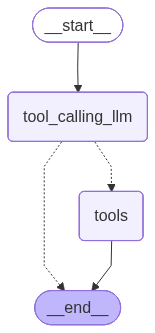

In [49]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
res = graph.invoke({"messages":"what date is today?"})

In [52]:
res['messages'][-1].content

'{"query": "today\'s date", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.datetoday.net/", "title": "What is the date today? Today\'s Date", "content": "Today\'s Date is Sat Jan 17 2026. About Date Today. The term \\"Date Today\\" refers to the current calendar date as determined by a system\'s internal clock", "score": 0.8834878, "raw_content": null}, {"url": "https://isotropic.org/date/", "title": "Today\'s Date - isotropic.org", "content": "Today is: ; Islamic: 28 Rajab 1447 ; Hebrew: 28 Teveth 5786 ; Julian: 4 January 2026 ; ISO: Day 6 of week 3 of 2026 ; Persian: 28 Dey 1404.", "score": 0.8412138, "raw_content": null}, {"url": "https://www.inchcalculator.com/what-is-todays-date/", "title": "What Is Today\'s Date? - Inch Calculator", "content": "Today, January 17th , is day 17 of 365 total days in 2026. What is Today\'s Date in Numbers? Today\'s date in numbers is: MM-DD-YYYY: 01-17-2026; DD-MM-YYYY:", "score": 0.80625874, "raw_content"

In [53]:
mul = graph.invoke({"messages":"what is 2*3"})
mul['messages'][-1].content

'6.0'

In [55]:
res = graph.invoke({"messages":"what date is today? and what is 2*3"})
res['messages']

[HumanMessage(content='what date is today? and what is 2*3', additional_kwargs={}, response_metadata={}, id='f01606f7-18fd-4e0e-a681-b603d66505ba'),
 AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking two things: today\'s date and the result of 2 multiplied by 3. Let me break this down.\n\nFirst, for the date, I need to check if there\'s a function available. Looking at the provided tools, there\'s a function called get_tavily_search_results which is for current events. But wait, the user is asking for the current date, which is a factual piece of information. However, the available functions don\'t include a date function. The other function is multiply, which can handle the 2*3 part. \n\nSo, for the date part, since there\'s no specific function to get the current date, I might need to rely on my own knowledge up to 2023. But the user might expect the current date when they\'re asking. However, without a dedicated function, I can\'t fetch real-tim

In [58]:
### Memory
from langgraph.checkpoint.memory import MemorySaver


In [61]:
config = {"configurable":{"thread_id":"1"}}

In [ ]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #if the tool is called then the next node is tools else the next node is end
    tools_condition)
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile(checkpointer=MemorySaver())

In [62]:
res = graph.invoke({"messages":"I am Hary"},config=config)
res['messages']

[HumanMessage(content='I am Hary', additional_kwargs={}, response_metadata={}, id='19830d97-efa0-47c0-a652-ee354f20b33b'),
 AIMessage(content='Hello, Hary! How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user said, "I am Hary." Let me think about how to respond.\n\nFirst, I need to acknowledge their introduction. Since they provided their name, a simple greeting would be appropriate. Maybe something like, "Hello, Hary! How can I assist you today?" That\'s friendly and opens the door for them to ask questions or share more.\n\nLooking at the tools provided, there\'s a get_tavily_search_results function for current events and a multiply function. But the user hasn\'t asked a question that requires a tool yet. They just introduced themselves, so I shouldn\'t call any functions right now. My response should be a regular message, not a tool call.\n\nI should make sure my reply is welcoming and encourages them to ask for help. No need to use any functions her

In [64]:
res = graph.invoke({"messages":"What is my name?"},config=config)
res['messages']

[HumanMessage(content='I am Hary', additional_kwargs={}, response_metadata={}, id='19830d97-efa0-47c0-a652-ee354f20b33b'),
 AIMessage(content='Hello, Hary! How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, the user said, "I am Hary." Let me think about how to respond.\n\nFirst, I need to acknowledge their introduction. Since they provided their name, a simple greeting would be appropriate. Maybe something like, "Hello, Hary! How can I assist you today?" That\'s friendly and opens the door for them to ask questions or share more.\n\nLooking at the tools provided, there\'s a get_tavily_search_results function for current events and a multiply function. But the user hasn\'t asked a question that requires a tool yet. They just introduced themselves, so I shouldn\'t call any functions right now. My response should be a regular message, not a tool call.\n\nI should make sure my reply is welcoming and encourages them to ask for help. No need to use any functions her

### Streaming
- 2 Types 
1. stream()
2. astream()
   

**2 mode are update and value**